# Multi-view vs Single-view Spectral Clustering

In [1]:
import numpy as np
from numpy.random import multivariate_normal
from mvlearn.cluster.mv_spectral import MultiviewSpectralClustering
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_moons
from sklearn.metrics import normalized_mutual_info_score as nmi_score
import matplotlib
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore') # Ignore warnings
%matplotlib inline
RANDOM_SEED=10

##### A function to generate 2 views of data for 2 classes

This function takes parameters for means, variances, and number of samples for class and generates data based on those parameters. The underlying probability distribution of the data is a multivariate gaussian distribution.

In [2]:
def create_data(seed, vmeans, vvars, num_per_class=500):
    
    np.random.seed(seed)
    data = [[],[]]
    
    for view in range(2):
        for comp in range(len(vmeans[0])):
            cov = np.eye(2) * vvars[view][comp]
            comp_samples = np.random.multivariate_normal(vmeans[view][comp], cov, size=num_per_class)
            data[view].append(comp_samples)
    for view in range(2):
        data[view] = np.vstack(data[view])
    
    labels = list()
    for ind in range(len(vmeans[0])):
        labels.append(ind * np.ones(num_per_class,))
    
    labels = np.concatenate(labels)
    
    return data, labels

##### Creating a function to display data and the results of clustering

The following function plots both views of data given a dataset and corresponding labels.

In [3]:
def display_plots(pre_title, data, labels):
    
    # plot the views
    plt.figure()
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    dot_size=10
    ax[0].scatter(data[0][:, 0], data[0][:, 1],c=labels,s=dot_size)
    ax[0].set_title(pre_title + ' View 1')
    ax[0].axes.get_xaxis().set_visible(False)
    ax[0].axes.get_yaxis().set_visible(False)

    ax[1].scatter(data[1][:, 0], data[1][:, 1],c=labels,s=dot_size)
    ax[1].set_title(pre_title + ' View 2')
    ax[1].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)

    plt.show()

##### Creating a function to perform both single-view and multi-view spectral clustering

In the following function, we will perform single-view spectral clustering on the two views separately and on them concatenated together. We also perform multi-view clustering using the multi-view algorithm. We will also compare the performance of multi-view and single-view versions of spectral clustering. We will evaluate the purity of the resulting clusters from each algorithm with respect to the class labels using the normalized mutual information metric.

In [4]:
def perform_clustering(seed, m_data, labels, n_clusters, kernel='rbf'):

    #################Single-view spectral clustering#####################
    # Cluster each view separately
    s_spectral = SpectralClustering(n_clusters=n_clusters, random_state=RANDOM_SEED, 
                                    affinity=kernel, n_init=100)
    s_clusters_v1 = s_spectral.fit_predict(m_data[0])
    s_clusters_v2 = s_spectral.fit_predict(m_data[1])

    # Concatenate the multiple views into a single view
    s_data = np.hstack(m_data)
    s_clusters = s_spectral.fit_predict(s_data)

    # Compute nmi between true class labels and single-view cluster labels
    s_nmi_v1 = nmi_score(labels, s_clusters_v1)
    s_nmi_v2 = nmi_score(labels, s_clusters_v2)
    s_nmi = nmi_score(labels, s_clusters)
    print('Single-view View 1 NMI Score: {0:.3f}\n'.format(s_nmi_v1))
    print('Single-view View 2 NMI Score: {0:.3f}\n'.format(s_nmi_v2))
    print('Single-view Concatenated NMI Score: {0:.3f}\n'.format(s_nmi))

    #################Multi-view spectral clustering######################

    # Use the MultiviewSpectralClustering instance to cluster the data
    m_spectral = MultiviewSpectralClustering(n_clusters=n_clusters, random_state=RANDOM_SEED, 
                        affinity=kernel, n_init=100)
    m_clusters = m_spectral.fit_predict(m_data)

    # Compute nmi between true class labels and multi-view cluster labels
    m_nmi = nmi_score(labels, m_clusters)
    print('Multi-view Concatenated NMI Score: {0:.3f}\n'.format(m_nmi))
    
    return m_clusters

##### General experimentation procedures

For each of the experiments below, we run both single-view spectral clustering and multi-view spectral clustering. For evaluating single-view performance, we run the algorithm on each view separately as well as all views concatenated together. We evalaute performance using normalized mutual information, which is a measure of cluster purity with respect to the true labels. For both algorithms, we use an n_init value of 100, which means that we run each algorithm across 100 random cluster initializations and select the best clustering results with respect to cluster inertia (within cluster sum-of-squared distances).

## Performance when cluster components in both views are well separated

Cluster components 1:
* Mean: [3, 3] (both views)
* Covariance = I (both views)

Cluster components 2:
* Mean = [0, 0] (both views)
* Covariance = I (both views)

As we can see, multi-view spectral clustering performs better than single-view spectral clustering for all 3 inputs.

Single-view View 1 NMI Score: 0.896

Single-view View 2 NMI Score: 0.870

Single-view Concatenated NMI Score: 0.981

Multi-view Concatenated NMI Score: 0.990



<Figure size 432x288 with 0 Axes>

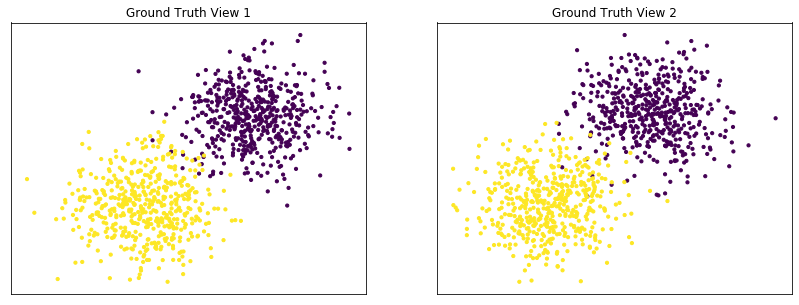

<Figure size 432x288 with 0 Axes>

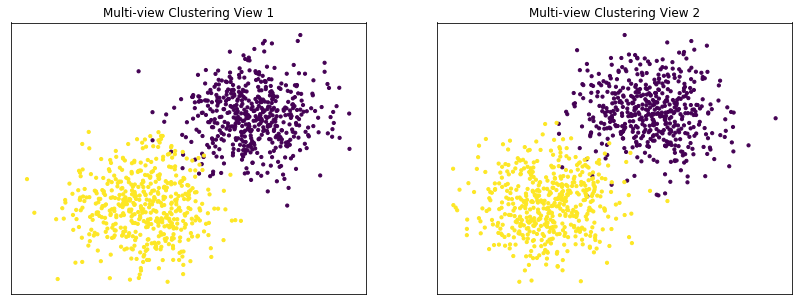

In [5]:
v1_means = [[3, 3], [0, 0]]
v2_means = [[3, 3], [0, 0]]
v1_vars = [1, 1]
v2_vars = [1, 1]
vmeans = [v1_means, v2_means]
vvars = [v1_vars, v2_vars]

data, labels = create_data(RANDOM_SEED, vmeans, vvars)
m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

## Performance when cluster components are relatively inseparable (highly overlapping) in both views

Cluster components 1:
* Mean: [0.5, 0.5] (both views)
* Covariance = I (both views)

Cluster components 2:
* Mean = [0, 0] (both views)
* Covariance = I (both views)

As we can see, multi-view spectral clustering performs about as poorly as single-view spectral clustering on all 3 input types.

Single-view View 1 NMI Score: 0.064

Single-view View 2 NMI Score: 0.049

Single-view Concatenated NMI Score: 0.105

Multi-view Concatenated NMI Score: 0.110



<Figure size 432x288 with 0 Axes>

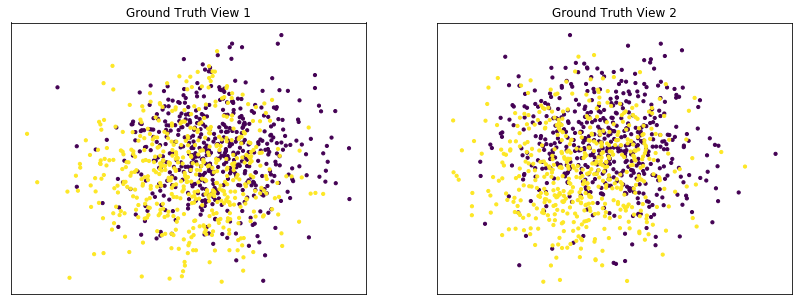

<Figure size 432x288 with 0 Axes>

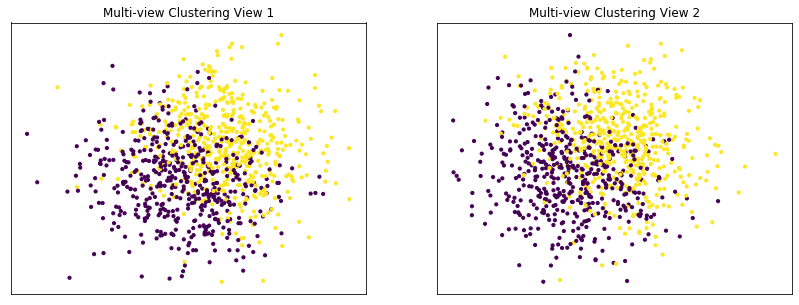

In [6]:
v1_means = [[0.5, 0.5], [0, 0]]
v2_means = [[0.5, 0.5], [0, 0]]
v1_vars = [1, 1]
v2_vars = [1, 1]
vmeans = [v1_means, v2_means]
vvars = [v1_vars, v2_vars]

data, labels = create_data(RANDOM_SEED, vmeans, vvars)
m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

## Performance when cluster components are somewhat separable (somewhat overlapping) in both views

Cluster components 1:
* Mean: [1.5, 1.5] (both views)
* Covariance = I (both views)

Cluster components 2:
* Mean = [0, 0] (both views)
* Covariance = I (both views)


As we can see, multi-view spectral clustering performs better than single-view spectral clustering for all 3 inputs.

Single-view View 1 NMI Score: 0.410

Single-view View 2 NMI Score: 0.413

Single-view Concatenated NMI Score: 0.661

Multi-view Concatenated NMI Score: 0.649



<Figure size 432x288 with 0 Axes>

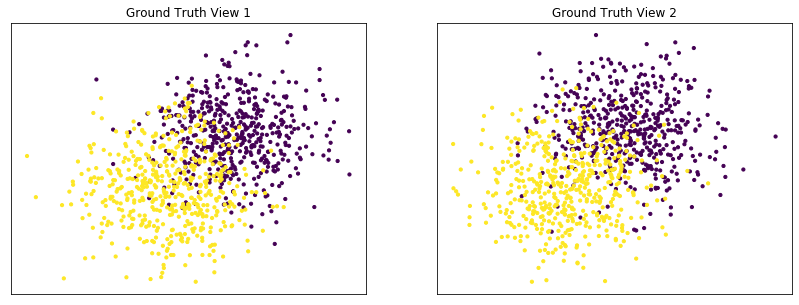

<Figure size 432x288 with 0 Axes>

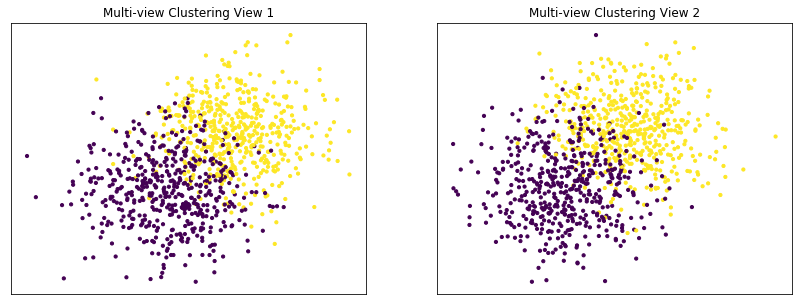

In [7]:
v1_means = [[1.5, 1.5], [0, 0]]
v2_means = [[1.5, 1.5], [0, 0]]
v1_vars = [1, 1]
v2_vars = [1, 1]
vmeans = [v1_means, v2_means]
vvars = [v1_vars, v2_vars]

data, labels = create_data(RANDOM_SEED, vmeans, vvars)
m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

## Performance when cluster components are highly overlapping in one view

Cluster components 1:
* Mean: View 1 = [0.5, 0.5], View 2 = [2, 2] 
* Covariance = I (both views)

Cluster components 2:
* Mean = [0, 0] (both views)
* Covariance = I (both views)

As we can see, multi-view spectral clustering performs worse than single-view spectral clustering on the concatenated data and with the best view as input.

Single-view View 1 NMI Score: 0.064

Single-view View 2 NMI Score: 0.588

Single-view Concatenated NMI Score: 0.610

Multi-view Concatenated NMI Score: 0.393



<Figure size 432x288 with 0 Axes>

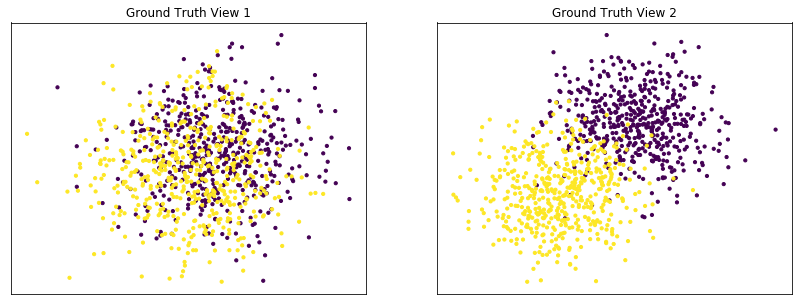

<Figure size 432x288 with 0 Axes>

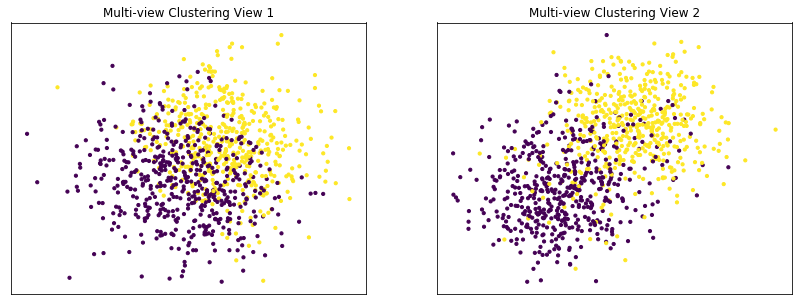

In [8]:
v1_means = [[0.5, 0.5], [0, 0]]
v2_means = [[2, 2], [0, 0]]
v1_vars = [1, 1]
v2_vars = [1, 1]
vmeans = [v1_means, v2_means]
vvars = [v1_vars, v2_vars]

data, labels = create_data(RANDOM_SEED, vmeans, vvars)
m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2)
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

## Performance on moons data

For this experiment, we use the sklearn make_moons function to make two interleaving half circles. We then use spectral clustering to separate the two views. In this experiment, the two views are identical. This experiment demonstrates the efficacy of using multi-view spectral clustering for non-convex clusters.

In [9]:
def create_moons(seed, num_per_class=500):
    
    np.random.seed(seed)
    data = []
    labels = []
    
    for view in range(2):
        v_dat, v_labs = make_moons(num_per_class*2, 
                random_state=seed + view, noise=0.05, shuffle=False)
        if view == 1:
            v_dat = v_dat[:, ::-1]
        
        data.append(v_dat)
    for ind in range(len(data)):
        labels.append(ind * np.ones(num_per_class,))
    labels = np.concatenate(labels)
    
    return data, labels

Single-view View 1 NMI Score: 1.000

Single-view View 2 NMI Score: 1.000

Single-view Concatenated NMI Score: 1.000

Multi-view Concatenated NMI Score: 1.000



<Figure size 432x288 with 0 Axes>

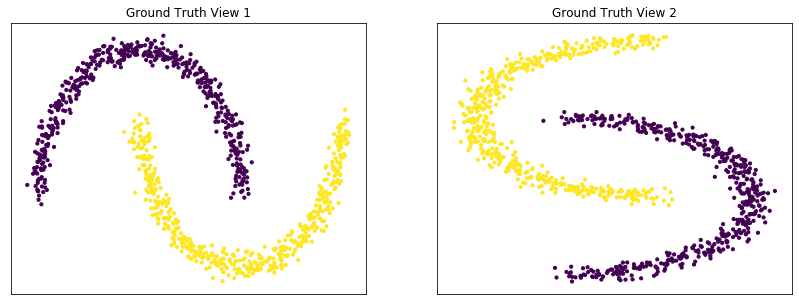

<Figure size 432x288 with 0 Axes>

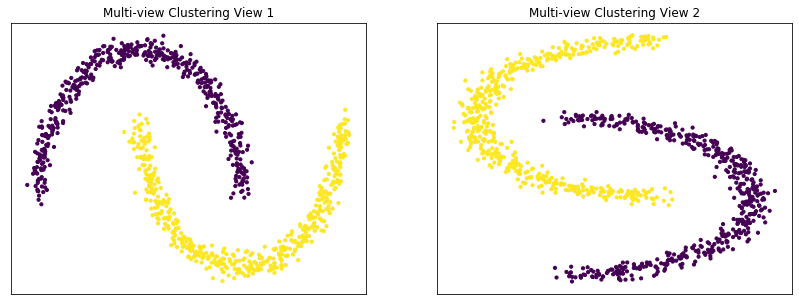

In [10]:
data, labels = create_moons(RANDOM_SEED)
m_clusters = perform_clustering(RANDOM_SEED, data, labels, 2, kernel='nearest_neighbors')
display_plots('Ground Truth' ,data, labels)
display_plots('Multi-view Clustering' ,data, m_clusters)

## Conclusions

From the above experiments, we can see some of the advantages and limitations of multi-view spectral clustering. We can see that it outperforms single-view spectral clustering when data views are both informative and relatively separable. However, when one view is particularly inseparable, it can perform worse than its single-view analog. Additionally, we can see that the clustering algorithm is capable of clustering nonconvex-shaped clusters. These results were obtained using simple, simulated data, so results may vary on more complex data from the real world.